In [1]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor, sam_model_registry)
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Hyper-parameters

In [2]:
DATA_ROOT = './data/hypernerf/misc/espresso'
MODEL_PATH = './output/hypernerf/misc/espresso'
CFG_PATH = './arguments/hypernerf/default.py'
FEATURE_DIM = 32

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = CFG_PATH)
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.object_masks = True
dataset.need_gt_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode)

Looking for config file in ./output/hypernerf/misc/espresso/feature_cfg_args
Config file found at: ./output/hypernerf/misc/espresso/feature_cfg_args
ID Encoding Dimension:  32
mode:  feature
Loading trained model at iteration 14000
load finished


195it [00:00, 65778.45it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [10.67854691 26.7673893  64.95144653] [-17.40277481 -21.40996552   5.76131248]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 10.6785,  26.7674,  64.9514],
        [-17.4028, -21.4100,   5.7613]])


loading model from exists./output/hypernerf/misc/espresso/point_cloud/iteration_14000


## Begin Segmentation

In [4]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

train_cams = [i for i in scene.getTrainCameras()]
video_cameras = [i for i in scene.getVideoCameras()]
cam_type = scene.dataset_type
print("train views:", len(train_cams))
print("video views:",len(video_cameras))

train views: 195
video views: 777


In [5]:
def plot(img_list, axis=False):
    l = len(img_list)
    for i, img in enumerate(img_list):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if axis == False:
            plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


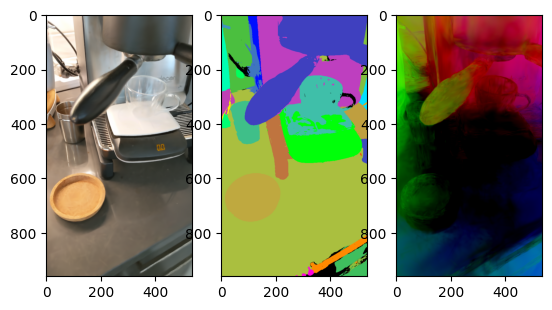

In [46]:
ref_img_camera_id = 0
mask_img_camera_id = 0
ref_view = train_cams[ref_img_camera_id]

with torch.no_grad():
    rendering = render(ref_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    # img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    objects = ref_view.objects
    
    identity_encoding = render_contrastive_feature(ref_view, gaussians, pipeline, bg_feature)["render"]
    logits = gaussians._classifier(identity_encoding)
    pred_obj = torch.argmax(logits,dim=0).cpu().numpy()
    
    import numpy as np
    from sklearn.decomposition import PCA
    identity_encoding = torch.nn.functional.normalize(identity_encoding, dim=0)
    X = identity_encoding.permute([1, 2, 0]).flatten(0, 1).cpu().numpy()
    np.random.seed(6)
    pca = PCA(n_components=3)
    pca.fit(X)
    X_rgb = pca.transform(X).reshape(*identity_encoding.shape[-2:], 3)
    # X_rgb = 255 * (X_rgb - X_rgb.min()) / (X_rgb.max() - X_rgb.min())
    
    plot([img, visualize_obj(pred_obj), X_rgb], axis=True)

In [49]:
pred_obj[400, 60]

46

In [52]:
# # hypernerf/interp/chickchicken
# egg = 37
# hand = 23
# board = 22
# white_egg = 29

# # hypernerf/misc/split-cookie
# cookie = 18
# hand = 35
# circle = 19

# # hypernerf/interp/torchocolate
# flame = [66, 67]
# chocolate = [65, 31, 77]

# # hypernerf/misc/americano
# hand = 29
# cup = 16
# americano = 14

# hypernerf/slice-banana
# slice_banana = [34, 16, 39, 9, 25, 24, 28, 22]

# hypernerf/espresso
espresso = [4, 41]
plate = [52]
metal_cup = [46]
machine = [48]

selected_objects = machine

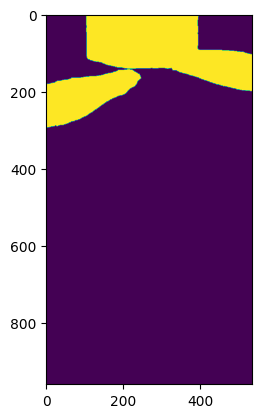

In [53]:
ref_view = train_cams[20]
selected_obj_ids = torch.tensor(selected_objects).cuda()
objects = ref_view.objects.cuda()
gt_mask = (objects[..., None] == selected_obj_ids[None, None, :])
gt_mask = gt_mask.any(dim=-1).squeeze().int()
plt.imshow(gt_mask.detach().cpu())

tensor(29872, device='cuda:0')


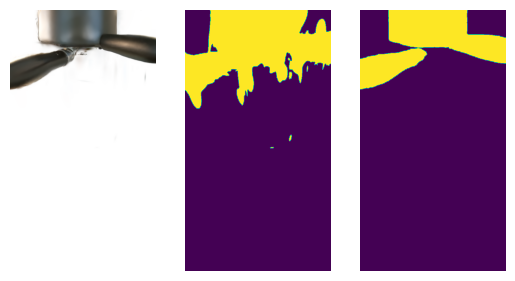

In [59]:
with torch.no_grad():
    means3D = gaussians.get_xyz
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    
    identity_encoding = gaussians._mlp(means3D, ts)
    logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
    prob_obj3d = torch.softmax(logits3d, dim=0)
    obj3d = torch.argmax(prob_obj3d, dim=0)
    hard_mask3d = (obj3d[..., None] == selected_obj_ids[None, :]).any(dim=-1).squeeze()
    soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > 0.3).any(dim=0).squeeze()
    mask3d = soft_mask3d # hard_mask3d & soft_mask3d
    # mask3d = mask.any(dim=0).squeeze()
    print(mask3d.count_nonzero())
    
    # plot
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=mask3d.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    plot([target_img_seg, rendered_mask, gt_mask.detach().cpu()])

tensor(28972, device='cuda:0')


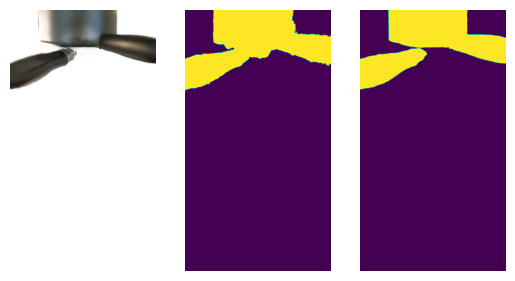

In [60]:
final_mask = mask3d.float().detach().clone().unsqueeze(-1)
final_mask.requires_grad = True
rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=final_mask)['mask'].squeeze()
# loss =  30 * torch.pow(gt_mask - rendered_mask, 2).sum()
loss = - (gt_mask * rendered_mask).sum() + 2 * ((1 - gt_mask) * rendered_mask).sum()
loss.backward()

grad_score = final_mask.grad.clone()
final_mask = final_mask - 10000 * grad_score
final_mask[final_mask < 0] = 0
final_mask[final_mask != 0] = 1
final_mask *= mask3d.float().unsqueeze(-1)
final_mask = final_mask.squeeze().bool()
print(final_mask.count_nonzero())

with torch.no_grad():
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, final_mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=final_mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    plot([target_img_seg, rendered_mask, gt_mask.detach().cpu()])

In [200]:
# from utils.segment_utils import *

# render_images = []
# with torch.no_grad():
#     for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
#         if idx == 0: time1 = time.time()
        
#         means3D = gaussians.get_xyz
#         ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
#         identity_encoding = gaussians._mlp(means3D, ts)
#         logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
#         prob_obj3d = torch.softmax(logits3d, dim=0)
#         # obj3d = torch.argmax(prob_obj3d, dim=0)
#         # hard_mask3d = (obj3d[..., None] == selected_obj_ids[None, :]).any(dim=-1).squeeze()
#         soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > prob_thresh).any(dim=0).squeeze()
#         mask3d = soft_mask3d # hard_mask3d & soft_mask3d
        
#         rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
#         render_images.append(to8b(rendering.detach()).transpose(1,2,0))

# time2 = time.time()
# print("FPS:", len(video_cameras) / (time2 - time1))
# torch.cuda.empty_cache()
    
# imageio.mimwrite('demo/seg_americano_raw.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/526 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 526/526 [00:16<00:00, 31.63it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 31.624278888663856


[swscaler @ 0x7255f40] Warning: data is not aligned! This can lead to a speed loss


## Create a mask_table.

In [64]:
prob_thresh = 0.3
outlier_factor = None
radii_factor = None
lamb_neg = 2
learning_rate = 10000
interval = 2

In [65]:
gaussians.create_mask_table((len(train_cams)+interval-1) // interval)
count = 0
time1 = time.time()
for idx, view in enumerate(tqdm(train_cams)):
    if idx % interval: continue
    with torch.no_grad():
        gaussians._time_map[count] = view.time
        
        means3D = gaussians.get_xyz
        ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
        identity_encoding = gaussians._mlp(means3D, ts)
        logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
        prob_obj3d = torch.softmax(logits3d, dim=0)
        # obj3d = torch.argmax(prob_obj3d, dim=0)
        # hard_mask3d = (obj3d[..., None] == selected_obj_ids[None, :]).any(dim=-1).squeeze()
        soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > prob_thresh).any(dim=0).squeeze()
        mask3d = soft_mask3d # hard_mask3d & soft_mask3d
        gt_mask = (view.objects.cuda()[..., None] == selected_obj_ids[None, None, :]).any(dim=-1).squeeze().int()
        gaussians._mask_table[count] = mask3d
        
        # tmp_mask = torch.zeros((num_sample, self._xyz.shape[0])).cuda().bool()
        # remove outliers
        if outlier_factor is not None:
            mask3d[mask3d.clone()] = points_inside_convex_hull(gaussians.get_xyz, mask3d, outlier_factor=outlier_factor)
            gaussians._mask_table[count] = mask3d
            # _, filtered_mask = statistical_filtering(gaussians.get_xyz, mask3d, max_time=1)
            # mask3d[mask3d.clone()] = filtered_mask
        
        render_pkg = render_segmentation(view, gaussians, pipeline, bg_color, mask3d.bool())
        if radii_factor is not None:
            # render_pkg = render_segmentation(view, gaussians, pipeline, bg_color, mask3d.bool())
            # remove Gaussians with extremely large radii
            radii = render_pkg["radii"].float()
            mask = (radii <= radii.mean() + radii_factor * radii.std())
            mask3d[mask3d.clone()] = mask
            gaussians._mask_table[count] = mask3d
            points2d = render_pkg['points2d'][mask].round().long()
        else:
            points2d = render_pkg['points2d'].round().long()
        
        # remove Gaussians outside the gt_mask
        in_mask = (points2d[:, 1] >= 0) & (points2d[:, 1] < view.image_height) & (points2d[:, 0] >= 0) & (points2d[:, 0] < view.image_width)
        mask3d[mask3d.clone()] = in_mask
        visible_points2d = points2d[in_mask]
        points2d_values = gt_mask[visible_points2d[:, 1], visible_points2d[:, 0]]
        gaussians._mask_table[count][mask3d] = (points2d_values == 1)
    
    # remove ambiguous gaussians at the boundary
    tmp_mask = gaussians._mask_table[count].float()
    final_mask = tmp_mask.detach().clone().unsqueeze(-1)
    # final_mask = mask3d.float().detach().clone().unsqueeze(-1)
    final_mask.requires_grad = True
    rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask)['mask'].squeeze()
    # loss = 30 * torch.pow(gt_mask - rendered_mask, 2).sum()
    loss = - (gt_mask * rendered_mask).sum() + lamb_neg * ((1 - gt_mask) * rendered_mask).sum()
    loss.backward()

    grad_score = final_mask.grad.clone()
    final_mask = final_mask - learning_rate * grad_score
    final_mask[final_mask < 0] = 0
    final_mask[final_mask != 0] = 1
    # final_mask *= mask3d.float().unsqueeze(-1)
    final_mask *= tmp_mask.float().unsqueeze(-1)
    final_mask = final_mask.squeeze().bool()
    
    gaussians._mask_table[count] = final_mask.squeeze()
    del final_mask, loss, grad_score
    
    count += 1
    
time2 = time.time()
print("time:", time2 - time1)

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:06<00:00, 32.26it/s]

time: 6.046754598617554


In [67]:
hyper_param = {
    "prob_thresh": prob_thresh,
    "outlier_factor": outlier_factor,
    "radii_factor": radii_factor,
    "lamb_neg": lamb_neg,
    "learning_rate": learning_rate,
    "interval": interval
}
gaussians.save_mask_table(os.path.join(MODEL_PATH, "segment_results"), "plate", hyper_param)
# gaussians.save_seg_gs(os.path.join(MODEL_PATH, "segment_results"))

: 

## Inference

In [66]:
from utils.segment_utils import *

render_images = []
for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask.bool())["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/seg_machine.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/777 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 777/777 [00:05<00:00, 135.78it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 135.7556858192837


[swscaler @ 0x5fe8f40] Warning: data is not aligned! This can lead to a speed loss


In [117]:
type(video_cameras[1].time)

float

In [127]:
video_time = torch.linspace(180.0/525, 240.0/525, 90)
# print(video_time)

In [136]:
range(180, 240)[59]

239

In [210]:
from utils.segment_utils import *

render_images = []
for idx, t in enumerate(tqdm(range(150, 390), desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - video_cameras[t].time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(video_cameras[t], gaussians, pipeline, bg_color, mask.bool())["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/seg_americano_trunc.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/240 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 240/240 [00:01<00:00, 128.04it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 280.4885368852834


[swscaler @ 0x589af40] Warning: data is not aligned! This can lead to a speed loss


In [126]:
from utils.segment_utils import *

render_images = []
for idx, t in enumerate(tqdm(video_time, desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - t)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(video_cameras[idx], gaussians, pipeline, bg_color, mask.bool(), t)["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite('demo/seg_americano_interp.mp4', render_images, fps=30)

Rendering progress:   0%|          | 0/180 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 180/180 [00:01<00:00, 122.00it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 356.3815566490113


[swscaler @ 0x74acf40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [ ]:
test_views = [i for i in scene.getTestCameras()]

In [ ]:
target_view = test_views[0]
with torch.no_grad():
    diff = torch.abs(gaussians._time_map - target_view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]

    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
plt.subplot(1, 3, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(target_view.gt_mask.squeeze().int())
plt.axis('off')
plt.show()

In [ ]:
miou = 0.
macc = 0.
for idx, view in enumerate(tqdm(test_views)):
     #! render
     rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask3d.float())["mask"]
     rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.5
     # rendered_mask = rendered_mask.int()

     gt_mask = view.gt_mask.bool()
     
     #! metrics
     iou = (rendered_mask & gt_mask).sum() / (rendered_mask | gt_mask).sum()
     # iou += ((~rendered_mask) & (~gt_mask)).sum() / ((~rendered_mask) | (~gt_mask)).sum()
     # iou /= 2
     acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
     miou += iou
     macc += acc
     # print(miou)
     # break
     
     torch.cuda.empty_cache()

miou /= len(test_views)
macc /= len(test_views)
print("mIoU: %.4f" % (miou * 100))
print("mAcc: %.4f" % (macc * 100))